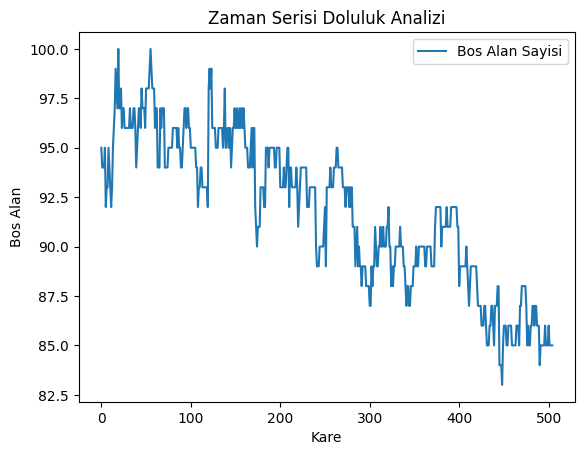

In [3]:
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
from playsound import playsound

# Noktaları dosyadan yükle
try:
    with open("n", "rb") as f:
        liste = pickle.load(f)
except FileNotFoundError:
    liste = []

# Resmi yükle ve boyutları al
img = cv2.imread("resim.png")
if img is None:
    print("Resim yüklenemedi!")
    exit()
img_height, img_width = img.shape[:2]  # Resim boyutlarını al

# Mouse olaylarını işleyen fonksiyon
def mouse(events, x, y, flags, params):
    if events == cv2.EVENT_LBUTTONDOWN:  # Sol tık ile nokta ekleme
        liste.append((x, y))
    elif events == cv2.EVENT_RBUTTONDOWN:  # Sağ tık ile nokta silme
        for i, pos in enumerate(liste):
            x1, y1 = pos
            if x1 < x < x1 + 60 and y1 < y < y1 + 15:  # Güncellenen boyutlar (60, 15)
                liste.pop(i)
                break  # Nokta silindikten sonra döngüyü durdur
    # Noktalar listesini dosyaya yaz
    with open("n", "wb") as f:
        pickle.dump(liste, f)

# Video kaynağını aç
cap = cv2.VideoCapture("otovideo.mp4")

# Zaman serisi doluluk analizi için liste
empty_space_history = []

def check(frame1):
    spacecounter = 0
    for idx, pos in enumerate(liste):
        x, y = pos

        crop = frame1[y:y + 15, x:x + 60]  # Güncellenen dikdörtgen boyutu (60, 15)
        count = cv2.countNonZero(crop)

        if count < 150:
            color = (0, 255, 0)  # Boş alan
            spacecounter += 1
        else:
            color = (0, 0, 255)  # Dolu alan

        # Her bir dikdörtgeni çiz
        cv2.rectangle(frame, (x, y), (x + 60, y + 15), color, 2)  # Boyut güncellendi
        cv2.putText(frame, str(idx + 1), (x + 20, y + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    # Boş alan sayısını ekrana yazdır
    total_spaces = len(liste)
    if total_spaces > 0:
        empty_percentage = (spacecounter / total_spaces) * 100
        occupied_percentage = 100 - empty_percentage

        cv2.putText(frame, f"Bos: {spacecounter}/{total_spaces}", (15, 24), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 4)
        cv2.putText(frame, f"Bos %: {empty_percentage:.1f}", (15, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 4)
        cv2.putText(frame, f"Dolu %: {occupied_percentage:.1f}", (15, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 4)

        # Eğer doluluk %90'ı geçerse uyarı ver
        if occupied_percentage > 90:
            playsound("alert.mp3")

    # Zaman serisi için boş alanları kaydet
    empty_space_history.append(spacecounter)

# Ana döngü
while True:
    # Video karesini oku
    ret, frame = cap.read()
    if not ret:  # Video bittiğinde döngüyü kır
        print("Video sona erdi veya okunamadı.")
        break

    # Video karesini resmin boyutuna yeniden boyutlandır
    frame = cv2.resize(frame, (img_width, img_height))  # Yeniden boyutlandır

    # Görüntü işleme adımları
    gri = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gri, (3, 3), 1)
    thres = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 25, 16)
    median = cv2.medianBlur(thres, 5)
    dilates = cv2.dilate(median, np.ones((3, 3)), iterations=1)

    # Kenar bulma sonuçlarını göstermek
    cv2.imshow("Kenarlar", dilates)
    
    # Kontrol fonksiyonunu çağır
    check(dilates)
    
    # Görüntüyü göster
    cv2.imshow("Video Oto", frame)
    cv2.setMouseCallback("Video Oto", mouse)  # Mouse callback ayarı

    # 'q' tuşuna basılırsa döngüyü sonlandır
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

# Video kaynağını serbest bırak ve pencereleri kapat
cap.release()
cv2.destroyAllWindows()

# Zaman serisi doluluk analizi grafiğini çiz
plt.plot(empty_space_history, label="Bos Alan Sayisi")
plt.xlabel("Kare")
plt.ylabel("Bos Alan")
plt.title("Zaman Serisi Doluluk Analizi")
plt.legend()
plt.show()
